### Import Libraries

In [1514]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [1515]:
url="https://gitlab.crio.do/me_notebook/me_jupyter_uberanalysis/-/raw/master/Uber_ride_analysis_dataset.csv"
df=pd.read_csv(url)
df.head(3)

,Request id,Pickup point,Drop point,Request timestamp,Start timestamp,Drop timestamp,Trip Cost,Extra Tip,Driver id,Trip Status,Ride Type,Payment Method,Weather
0,4386.0,Majestic Bus Station,Bangalore Palace,2021-07-13 0:00:24,NaN,NaN,0.00,0.0,61.0,Trip Cancelled,UberXL,NaN,Clear
1,4387.0,Lalbagh Botanical Garden,Indiranagar,2021-07-13 0:02:14,2021-07-13 0:16:00,2021-07-13 0:26:14,111.38,0.0,17.0,Trip Completed,UberGo,Cash,Cloudy
2,4388.0,Lalbagh Botanical Garden,Kormangala Police Station,2021-07-13 0:06:34,2021-07-13 0:14:01,2021-07-13 2:01:34,89.00,25.0,21.0,Trip Completed,UberXL,Card,Clear


In [1516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   float64
 1   Pickup point       6745 non-null   object 
 2   Drop point         6745 non-null   object 
 3   Request timestamp  6745 non-null   object 
 4   Start timestamp    5095 non-null   object 
 5   Drop timestamp     5095 non-null   object 
 6   Trip Cost          6745 non-null   float64
 7   Extra Tip          6745 non-null   float64
 8   Driver id          5970 non-null   float64
 9   Trip Status        6745 non-null   object 
 10  Ride Type          6745 non-null   object 
 11  Payment Method     5095 non-null   object 
 12  Weather            6745 non-null   object 
dtypes: float64(4), object(9)
memory usage: 705.5+ KB


### Data Cleaning

#### Handle Missing Values

In [1517]:
df.columns

Index(['Request id', 'Pickup point', 'Drop point', 'Request timestamp',
       'Start timestamp', 'Drop timestamp', 'Trip Cost', 'Extra Tip',
       'Driver id', 'Trip Status', 'Ride Type', 'Payment Method', 'Weather'],
      dtype='object')

In [1518]:
df.columns=df.columns.str.lower().str.strip().str.replace(" ","_")
df.columns

Index(['request_id', 'pickup_point', 'drop_point', 'request_timestamp',
       'start_timestamp', 'drop_timestamp', 'trip_cost', 'extra_tip',
       'driver_id', 'trip_status', 'ride_type', 'payment_method', 'weather'],
      dtype='object')

In [1519]:
df['trip_status'].value_counts()


trip_status
Trip Completed       5095
Trip Cancelled       1022
No Cars Available     628
Name: count, dtype: int64

#### Converting Date Columns into Datetime

In [1520]:
date_time_cols=['request_timestamp','start_timestamp','drop_timestamp']
for col in date_time_cols:
    df[col]=pd.to_datetime(df[col],errors='coerce')


In [1521]:
df.isnull().sum().sum()

8325

In [1522]:
df['driver_id']=df['driver_id'].fillna(-1)  # -1 for unassigned driver

In [1523]:
cols=['payment_method','ride_type', 'weather']
for col in cols:
    df[col]=df[col].fillna(df[col].mode()[0])



In [1524]:
cols=['trip_cost', 'extra_tip']
for col in cols:
    df[col]=df[col].fillna(df[col].median())

In [1525]:
df=df.dropna(subset=['request_id', 'pickup_point', 'drop_point'])

In [1526]:
df=df.drop_duplicates()

In [1527]:
df.isnull().sum()

request_id              0
pickup_point            0
drop_point              0
request_timestamp       0
start_timestamp      1650
drop_timestamp       1650
trip_cost               0
extra_tip               0
driver_id               0
trip_status             0
ride_type               0
payment_method          0
weather                 0
dtype: int64

In [1529]:
df.shape

(6745, 13)

In [1530]:
df['payment_method'].unique()

array(['Cash', 'Card', 'UPI'], dtype=object)

In [1531]:
df['ride_type'].unique()

array(['UberXL', 'UberGo', 'UberX'], dtype=object)

In [1532]:
df['trip_status'].value_counts()

trip_status
Trip Completed       5095
Trip Cancelled       1022
No Cars Available     628
Name: count, dtype: int64

In [1533]:
df.shape

(6745, 13)

#### Feature Engineering

In [1534]:
df['total_cost']=df['trip_cost']+df['extra_tip']


In [1535]:
df['trip_duration']=(df['drop_timestamp']-df['start_timestamp']).dt.total_seconds()/60
df['date']=pd.DatetimeIndex(df['start_timestamp']).date
df['hour'] = (df['start_timestamp']).dt.hour
df['minute'] = (df['start_timestamp']).dt.minute
df['day'] = df['start_timestamp'].dt.day_name()  # Monday, Tuesday, etc.
df['day-night']=pd.cut(x=df['hour'],bins=[0,10,15,19,24],labels=["morning","afternoon","evening","night"], right=False  )

### Detecting & Handling the Outliers

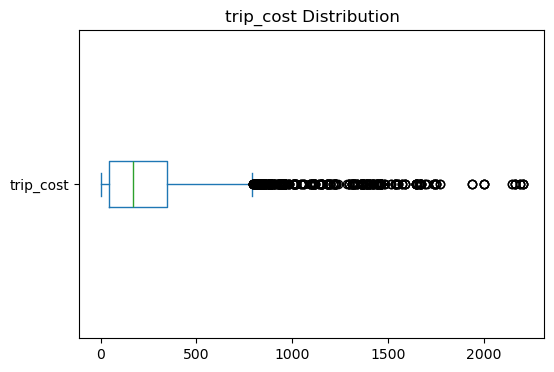

In [1536]:
# Plot boxplot for trip cost
plt.figure(figsize=(6, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution')
plt.show()

In [1537]:
numeric_cols=['trip_cost', 'extra_tip', 'total_cost']
print(numeric_cols)
for cols in numeric_cols:
    Q1=df[cols].quantile(0.25)
    Q3=df[cols].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    num_outliers=df[(df[cols]<lower)|(df[cols]>upper)].shape[0]
    print(f"{cols}: {num_outliers} outliers detected")

    df[cols]=df[cols].clip(lower,upper)

['trip_cost', 'extra_tip', 'total_cost']
trip_cost: 442 outliers detected
extra_tip: 100 outliers detected
total_cost: 445 outliers detected


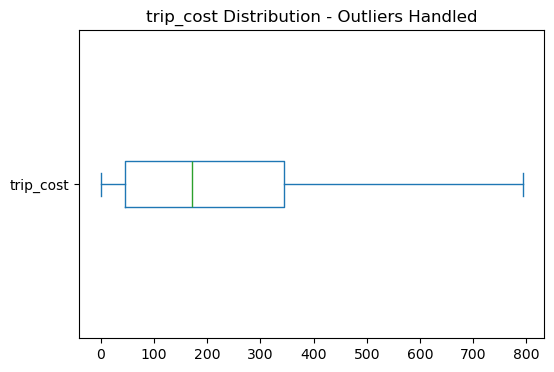

In [1538]:
# Plot boxplot for trip cost
plt.figure(figsize=(6, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution - Outliers Handled')
plt.show()


### 📊 Exploratory Data Analysis (EDA)

Now that the data cleaning is done, let's perform EDA to understand the dataset better and derive insights.


#### 1. Dataset Overview

In [1539]:
df.shape

(6745, 20)

In [1540]:
df.dtypes

request_id                  float64
pickup_point                 object
drop_point                   object
request_timestamp    datetime64[ns]
start_timestamp      datetime64[ns]
drop_timestamp       datetime64[ns]
trip_cost                   float64
extra_tip                   float64
driver_id                   float64
trip_status                  object
ride_type                    object
payment_method               object
weather                      object
total_cost                  float64
trip_duration               float64
date                         object
hour                        float64
minute                      float64
day                          object
day-night                  category
dtype: object

#### 2. Trip Status Breakdown

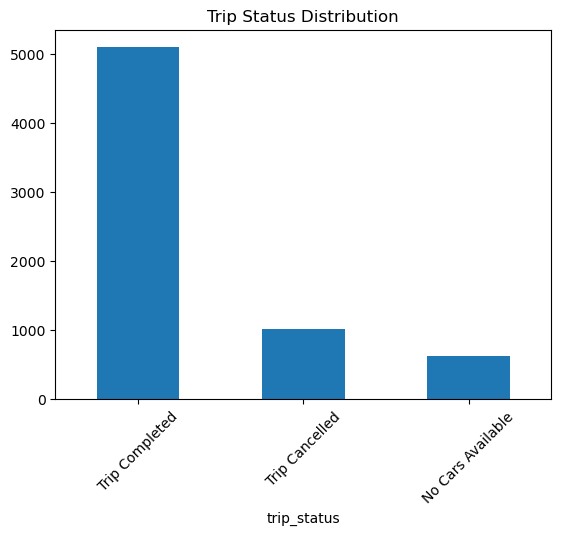

In [1541]:
plt.Figure(figsize=(2,4))
df['trip_status'].value_counts().plot(kind='bar')
plt.title("Trip Status Distribution")
plt.xticks(rotation=45)
plt.show()

In [1542]:
df['trip_status'].value_counts()

trip_status
Trip Completed       5095
Trip Cancelled       1022
No Cars Available     628
Name: count, dtype: int64

#### 3. Trip Cost Distribution

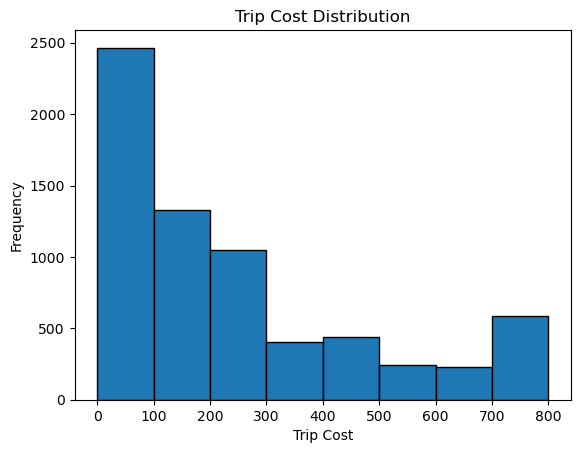

In [ ]:


max_cost = df['trip_cost'].max()
bins = np.arange(0, max_cost + 100, 100)
plt.Figure(figsize=(2,4))

df['trip_cost'].hist(bins=bins, edgecolor='black')
plt.title("Trip Cost Distribution")
plt.xlabel("Trip Cost")
plt.ylabel("Frequency")
plt.grid(False)  
plt.show()

#### 4. Analyze Payment Methods

In [1544]:
df.groupby('payment_method')['trip_cost'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

,mean,median,count
payment_method,,,
Card,316.517799,231.50,1708
UPI,315.056717,233.75,1663
Cash,156.880047,45.00,3374


#### 5. Trip Duration Analysis


In [1545]:
df['trip_duration_minutes'] = (df['drop_timestamp'] - df['start_timestamp']).dt.total_seconds() / 60

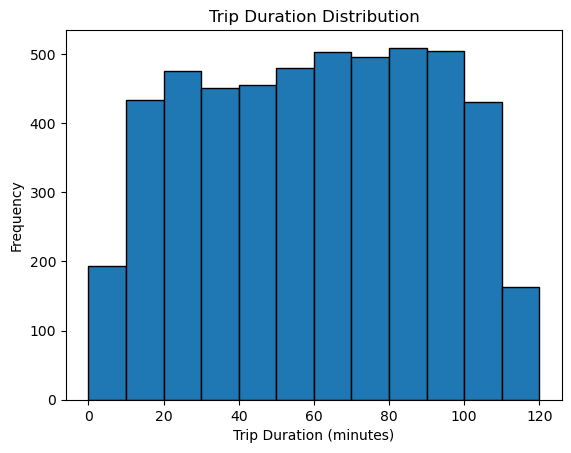

In [ ]:

max_duration = df['trip_duration_minutes'].max()
bins = np.arange(0, max_duration + 10, 10)  # bins of size 10 minutes
plt.Figure(figsize=(4,4))

# Plot histogram
df['trip_duration_minutes'].hist(bins=bins, edgecolor='black')
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(False)  
plt.show()

#### 3. Extract Date Time

In [1547]:
df['request_date'] = df['request_timestamp'].dt.date
df['start_date'] = df['start_timestamp'].dt.date
df['drop_date'] = df['drop_timestamp'].dt.date

df['request_day'] = df['request_timestamp'].dt.day_name()
df['start_day'] = df['start_timestamp'].dt.day_name()
df['drop_day'] = df['drop_timestamp'].dt.day_name()

df['request_time'] = df['request_timestamp'].dt.time
df['start_time'] = df['start_timestamp'].dt.time
df['drop_time'] = df['drop_timestamp'].dt.time

df['request_hour'] = df['request_timestamp'].dt.hour
df['start_hour'] = df['start_timestamp'].dt.hour
df['drop_hour'] = df['drop_timestamp'].dt.hour

#### 4. Ride Delay

In [1548]:
df["ride_delay"] = ((df["drop_timestamp"] - df["start_timestamp"]).dt.total_seconds() / 3600).round(2)

#### 5. Cancellation Reasons

In [1549]:
df['cancellation_reason'] = np.where(
    (df['driver_id'] == -1) & (df['trip_status'] == 'No Cars Available'), 'No Cabs',
    np.where(
        (df['driver_id'] == -1) & (df['trip_status'] == 'Trip Cancelled'), 'Passenger',
        np.where(
            (df['driver_id'] != -1) & (df['trip_status'] == 'Trip Cancelled'), 'Driver',
            'Trip Completed'
        )
    )
)

### Analysis

Selecting columns relevant to our analysis

In [1550]:
new_df = df[['request_id', 'driver_id', 'trip_status', 'request_day', 'request_hour','start_day', 'start_hour', 'drop_day', 'drop_hour', 'trip_cost',
            'ride_delay', 'weather', 'cancellation_reason']]

new_df.columns

Index(['request_id', 'driver_id', 'trip_status', 'request_day', 'request_hour',
       'start_day', 'start_hour', 'drop_day', 'drop_hour', 'trip_cost',
       'ride_delay', 'weather', 'cancellation_reason'],
      dtype='object')

#### Request Count Vs Day

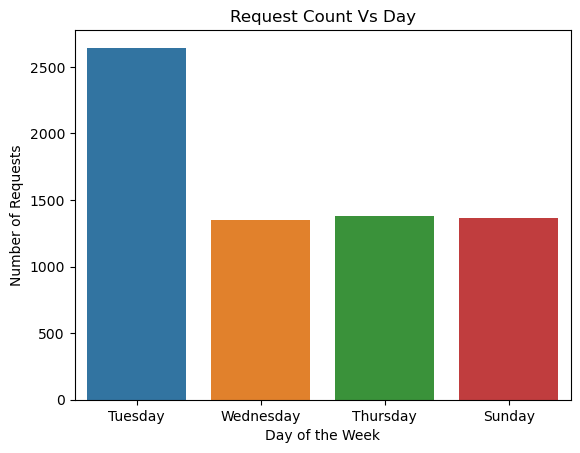

In [1551]:
sns.countplot(
    new_df,
    x='request_day',
    hue='request_day',  # This applies palette correctly
    # palette='BuGn',  # Try 'Set1', 'Pastel1', 'husl', 'coolwarm', etc.
    legend=False
)
plt.Figure(figsize=(2,6))
plt.title("Request Count Vs Day")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Requests")
plt.show()

#### Request Count Vs Hour

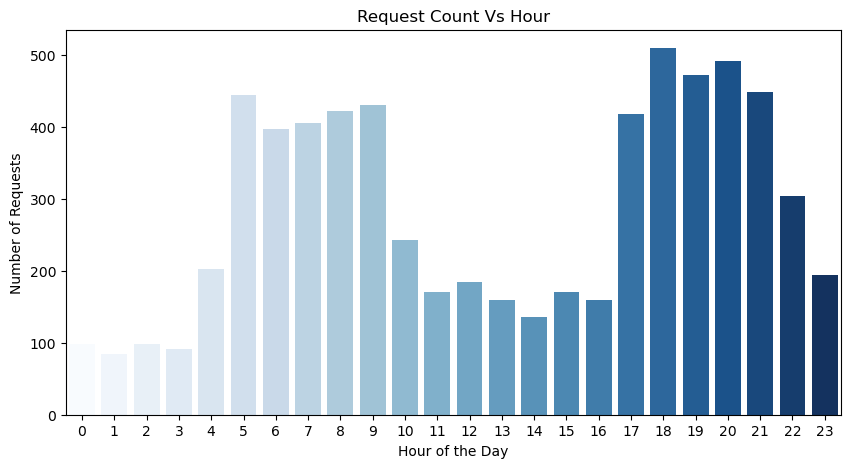

In [1552]:

plt.figure(figsize = (10, 5))

sns.countplot(
    new_df,
    x='request_hour',
    hue='request_hour',  # This applies palette correctly
    palette='Blues',  # Try 'Set1', 'Pastel1', 'husl', 'coolwarm', etc.
    legend=False
)

plt.title("Request Count Vs Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Requests")
plt.show()

In [1553]:
trip_status_rates = new_df['trip_status'].value_counts(normalize=True) * 100
print(trip_status_rates)

trip_status
Trip Completed       75.537435
Trip Cancelled       15.151964
No Cars Available     9.310600
Name: proportion, dtype: float64


#### Trip Status Bifurcation

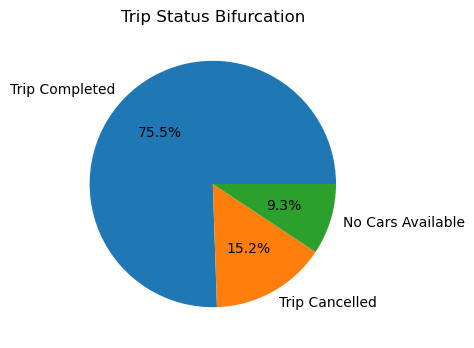

In [1554]:
plt.figure(figsize=(6, 4))
plt.pie(trip_status_rates , labels = trip_status_rates.index, autopct = '%1.1f%%')

plt.title("Trip Status Bifurcation")
plt.show()

#### Trip Cancellation Trend

Cancellation Trends (Driver vs Passenger):
cancellation_reason
Driver       875
Passenger    147
Name: count, dtype: int64


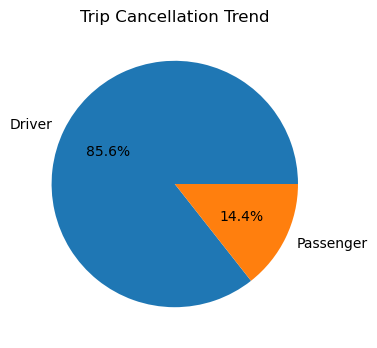

In [1555]:

cancellation_trends = new_df[new_df['trip_status'] == 'Trip Cancelled']['cancellation_reason'].value_counts()

# Print the cancellation trends
print(f"Cancellation Trends (Driver vs Passenger):")
print(cancellation_trends)

plt.figure(figsize=(6, 4))
plt.pie(cancellation_trends , labels = cancellation_trends.index, autopct = '%1.1f%%')

plt.title("Trip Cancellation Trend")
plt.show()

### Looking deeper into not completed trips

In [1556]:
selected_columns = [
    'request_id', 'pickup_point', 'drop_point',
    'driver_id', 'trip_status',
    'payment_method', 'weather',
    'request_day', 'request_hour',
    'cancellation_reason'
]
df_new = df[selected_columns]
df_incom_rides = df_new[df_new['trip_status'] != 'Trip Completed']
df_incom_rides.head()

,request_id,pickup_point,drop_point,driver_id,trip_status,payment_method,weather,request_day,request_hour,cancellation_reason
0,4386.0,Majestic Bus Station,Bangalore Palace,61.0,Trip Cancelled,Cash,Clear,Tuesday,0,Driver
3,4389.0,Majestic Bus Station,ISKCON Temple,-1.0,No Cars Available,Cash,Rainy,Tuesday,0,No Cabs
9,4395.0,UB City,Lalbagh Botanical Garden,2.0,Trip Cancelled,Cash,Clear,Tuesday,0,Driver
14,4400.0,KR Puram Railway Station,Embassy Tech Village,69.0,Trip Cancelled,Cash,Clear,Tuesday,0,Driver
17,4403.0,BTM Layout,Orion Mall,94.0,Trip Cancelled,Cash,Cloudy,Tuesday,0,Driver


#### Proportion of Incomplete Ride Statuses

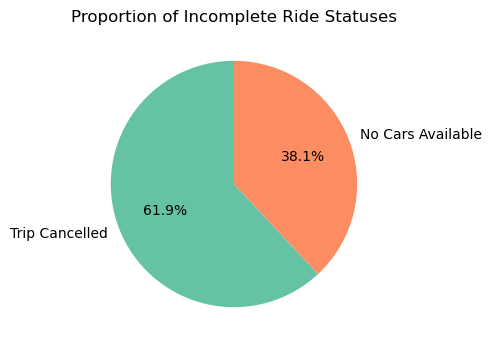

In [1557]:
trip_status_proportion = df_incom_rides['trip_status'].value_counts(normalize=True)*100

plt.figure(figsize=(6, 4))
plt.pie(trip_status_proportion, labels = trip_status_proportion.index, autopct='%1.1f%%',startangle=90,colors=sns.color_palette('Set2'))
plt.title('Proportion of Incomplete Ride Statuses')

plt.show()

#### Incomplete Rides by Day and Reason

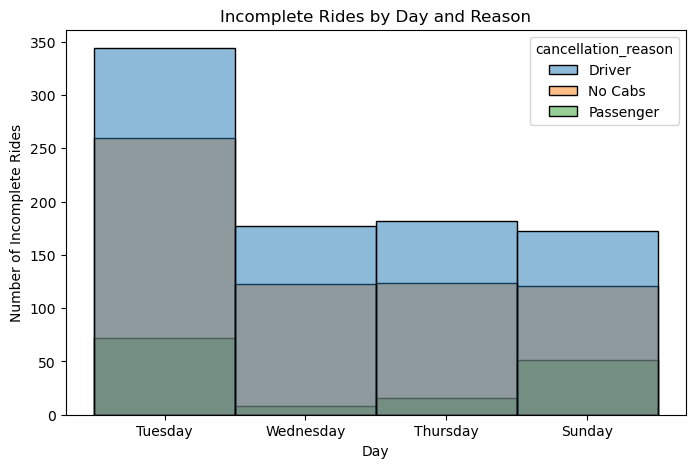

In [1558]:
plt.figure(figsize=(8, 5))

sns.histplot(x = 'request_day', hue='cancellation_reason', data = df_incom_rides, edgecolor = 'black')
plt.title('Incomplete Rides by Day and Reason')
plt.xlabel('Day')
plt.ylabel('Number of Incomplete Rides')
plt.show()

#### Incomplete Rides by Hour and Reason

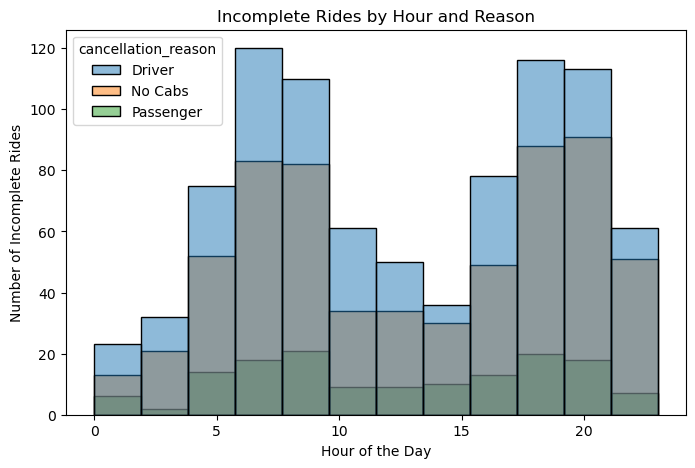

In [1559]:
plt.figure(figsize=(8, 5))

sns.histplot(x = 'request_hour', hue='cancellation_reason', data = df_incom_rides, edgecolor = 'black')
plt.title('Incomplete Rides by Hour and Reason')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incomplete Rides')
plt.show()

#### 4.Cancellations by Weather and Reason per Ride Type

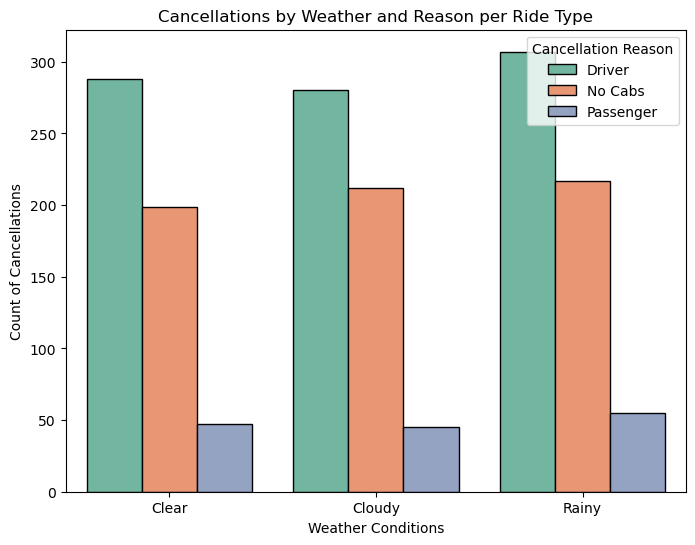

In [1560]:
weather_cancel = df_incom_rides.groupby(['weather', 'cancellation_reason']).size().reset_index(name='count')

# 2. Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    x='weather',
    y='count',
    hue='cancellation_reason',
    data=weather_cancel,
    palette='Set2',
    edgecolor='black'
)

# 3. Add title and axis labels
plt.title('Cancellations by Weather and Reason per Ride Type')
plt.xlabel('Weather Conditions')
plt.ylabel('Count of Cancellations')
plt.legend(title='Cancellation Reason')

# 4. Show the plot
plt.show()